# Importy, wizualizacja
(Należy odpalić i schować).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.decomposition import PCA
from torch import nn
from torch.utils.data import Subset
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import Compose, Lambda, ToTensor

%matplotlib inline


def plot_dataset(train_data, model):
    view_data = train_data.data[:5].view(-1, 28 * 28) / 255.0
    _, decoded_data = model.forward(train_data.data[:5].view(-1, 784).float().cuda() / 255.0)
    decoded_data = decoded_data.cpu().detach().numpy()

    n_rows = 2 if decoded_data is not None else 1
    n_cols = len(view_data)
    plt.suptitle("Reconstruction")
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

    if decoded_data is not None:
        for i in range(n_cols):
            axes[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap="gray")
            axes[0][i].set_xticks(())
            axes[0][i].set_yticks(())

        for i in range(n_cols):
            axes[1][i].clear()
            axes[1][i].imshow(np.reshape(decoded_data[i], (28, 28)), cmap="gray")
            axes[1][i].set_xticks(())
            axes[1][i].set_yticks(())

    else:
        for i in range(n_cols):
            axes[i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap="gray")
            axes[i].set_xticks(())
            axes[i].set_yticks(())

    plt.show()


def plot_pca(data, model):
    labels = data.classes
    plt.suptitle("Reduction of latent space")
    _ = plt.figure(figsize=(10, 6))
    pca = PCA(2)

    z = model.encode(train_data.data.view(-1, 784).float().cuda())
    reduced_z = pca.fit_transform(z.detach().cpu().numpy())

    for class_idx in range(10):
        indices = data.targets == class_idx
        plt.scatter(reduced_z[indices, 0], reduced_z[indices, 1], s=2.0, label=labels[class_idx])

    plt.legend()
    plt.show()


torch.manual_seed(1337)
batch_size = 128
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])

# Mnist dataset
train_data = MNIST(
    root=".", train=True, transform=transforms, download=True
)  # change to false if you already have the data

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# Auoenkoder i modele generatywne

Na dzisiejszych zajęciach poznamy model autoenkodera i pokażemy, kolejno:
1. Jak jego ukrytą reprezentację można wykorzystać do uczenia częściowo nadzorowanego
2. Jak można wymusić na autoenkoderze generatywność i "zmusić" go do generowania nowych przykładów podobnych do tych ze zbioru treningowego.


## Podstawowy autoenkoder

![Auto-encoder](https://raw.githubusercontent.com/gmum/ml2023-24/master/lab/resources/ae.png)

Autoenkoder rozumiemy jako sieć neuronową, która na wyjściu ma odtwarzać ten sam obiekt, który dostaje na wejściu. Zazwyczaj na autoenkoder patrzymy jako na połączenie dwóch modeli: enkodera $\mathcal{E}$ i dekodera $\mathcal{D}$. Interpretujemy działanie modelu w następujący sposób: enkoder kompresuje wejściowy przykład $x$ do wektora $y$, o którym myślimy jako o reprezentacji ukrytej. Dekoder na podstawie wektora $y$ produkuje $\hat{x}$, które ma aproksymować oryginalne wejście $x$. Tzn.:

$$
y = \mathcal{E} x 
$$
$$
\hat{x} = \mathcal{D} y
$$

Funkcją kosztu w autoenkoderze będzie MSE pomiędzy wejściem a wyjściem:
$$
\mathcal{L}_{AE} =\frac{1}{n}\sum_i \|x_i-\mathcal{D}\mathcal{E} x_i\|_2^2,
$$
 

Enkoder i dekoder mogą być dowolnymi sieciami neuronowymi, najczęściej jednak dekoder składa się z tych samych transformacji co enkoder w odwrotnej kolejności.  

## Zadanie 1. Vanilla Autoencoder (1 pkt.)

Należy zaimplementować enkoder i dekoder. Kolejne warstwy w enkoderze mają mieć następującą liczbę neuronów: [784, 128, 128, 64, `latent_dim`]. Analogicznie dekoder ma wyglądać następująco: [`latent_dim`, 64, 128, 128, 784]. Wejście i wyjście mają 784 neurony, jako że taka jest wymiarowość MNIST-a. Wartość `latent_dim` dostajemy na wejściu do konstruktora (`latent_dim`).

Po warstwach ukrytych chcemy mieć aktywacje ReLU, **na końcu enkodera nie stosujemy żadnej aktywacji**, na końcu dekodera stosujemy aktywację sigmoidalną.

**Pytanie: Dlaczego na końcu dekodera chcemy mieć sigmoidę?**

In [2]:
#ponieważ chcemy mieć wartości z przedziału [0,1], gdyż tyle wynoszą wartości dla MNIST, które określają odcień szarości
class AutoEncoder(torch.nn.Module):
    def __init__(self, latent_dim: int):
        
        super(AutoEncoder, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(784,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,self.latent_dim)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,784),
            torch.nn.Sigmoid()
        )
        
    def decode(self, encoded: torch.Tensor):
        return self.decoder(encoded)
    
    def encode(self, x: torch.Tensor):
        return self.encoder(x)

    def forward(self, x: torch.Tensor):
        # encode and decode
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return encoded, decoded

Epoch: 0  |  train loss: 0.0507


<Figure size 640x480 with 0 Axes>

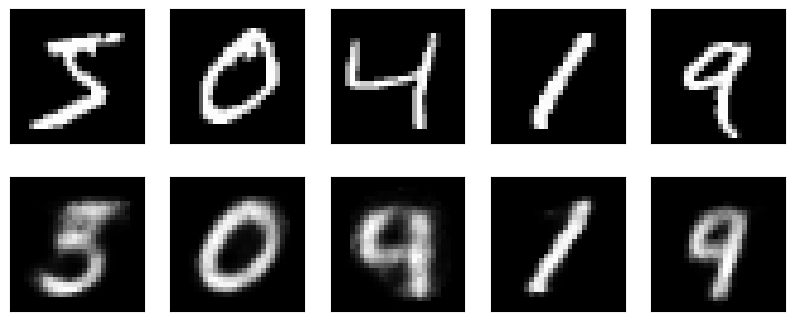

<Figure size 640x480 with 0 Axes>

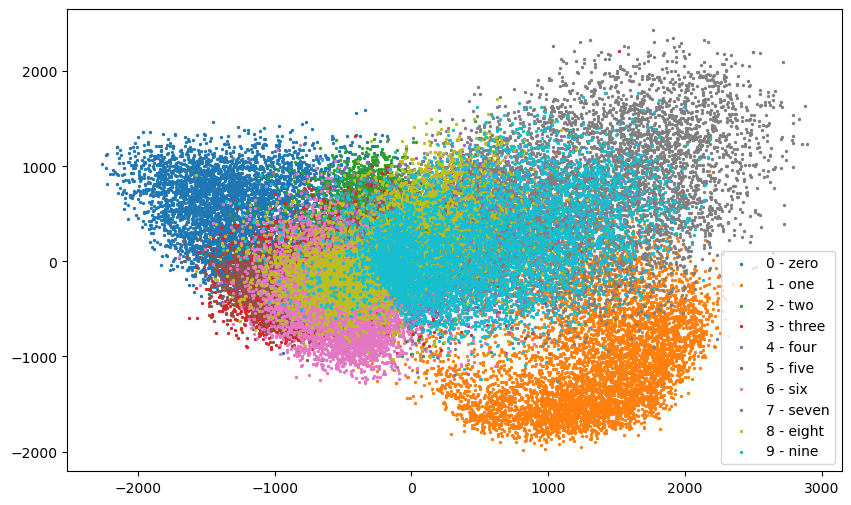

Epoch: 1  |  train loss: 0.0289
Epoch: 2  |  train loss: 0.0247
Epoch: 3  |  train loss: 0.0212
Epoch: 4  |  train loss: 0.0194
Epoch: 5  |  train loss: 0.0184
Epoch: 6  |  train loss: 0.0178
Epoch: 7  |  train loss: 0.0173
Epoch: 8  |  train loss: 0.0170
Epoch: 9  |  train loss: 0.0167
Epoch: 10  |  train loss: 0.0165


<Figure size 640x480 with 0 Axes>

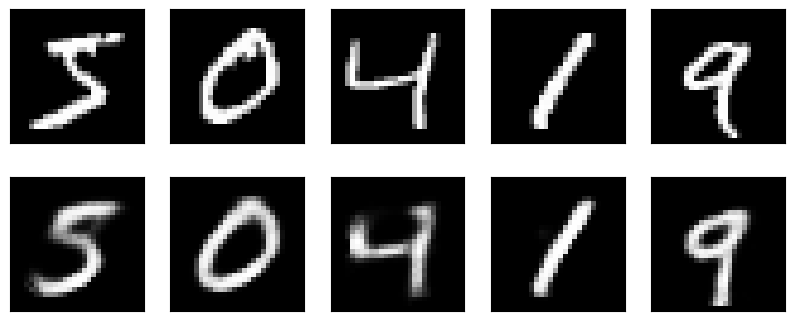

<Figure size 640x480 with 0 Axes>

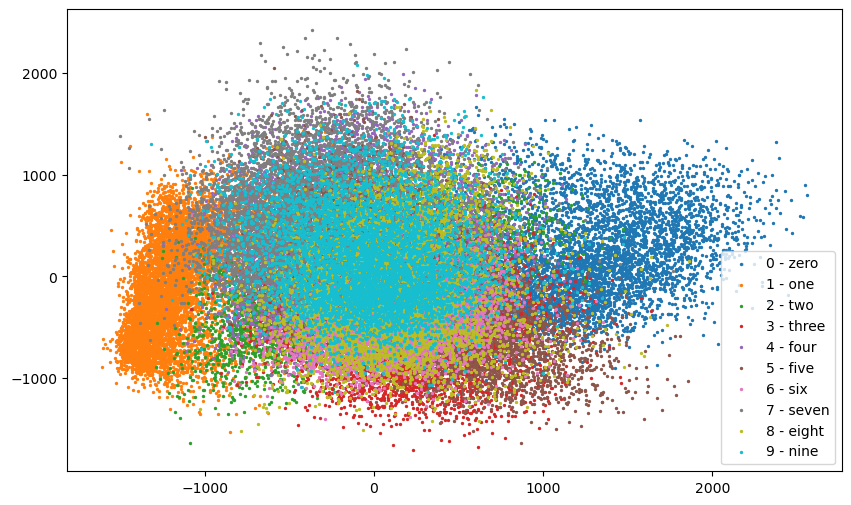

Epoch: 11  |  train loss: 0.0163
Epoch: 12  |  train loss: 0.0161
Epoch: 13  |  train loss: 0.0161
Epoch: 14  |  train loss: 0.0160
Epoch: 15  |  train loss: 0.0159
Epoch: 16  |  train loss: 0.0158
Epoch: 17  |  train loss: 0.0157
Epoch: 18  |  train loss: 0.0155
Epoch: 19  |  train loss: 0.0155
Epoch: 20  |  train loss: 0.0154


<Figure size 640x480 with 0 Axes>

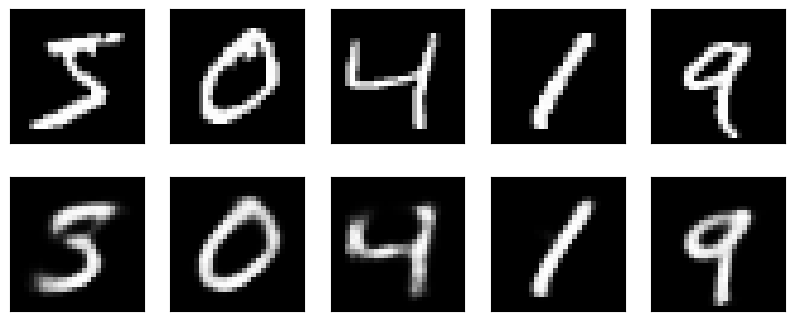

<Figure size 640x480 with 0 Axes>

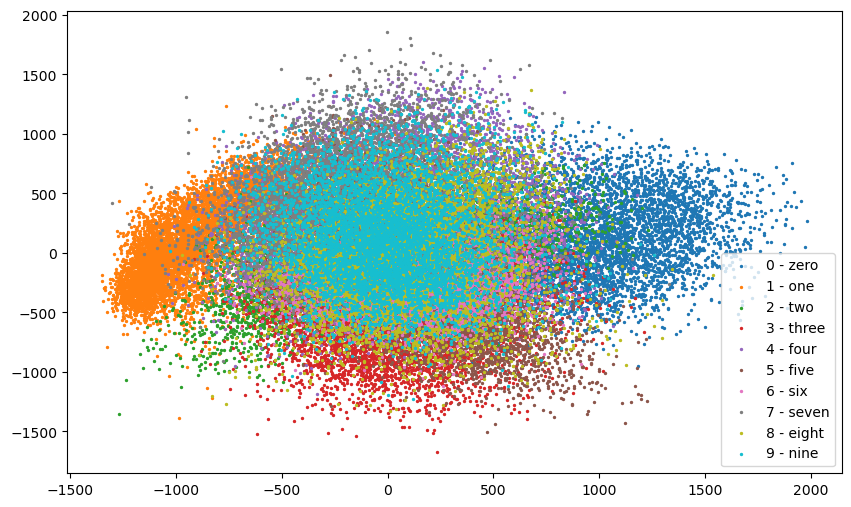

Epoch: 21  |  train loss: 0.0154
Epoch: 22  |  train loss: 0.0153
Epoch: 23  |  train loss: 0.0153
Epoch: 24  |  train loss: 0.0153


In [3]:
# Hyper Parameters
epochs: int = 25
LR: float = 5e-3  # learning rate

# prepare original data for plotting

autoencoder = AutoEncoder(latent_dim=10).cuda()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
rec_loss_fn = torch.nn.MSELoss()

for epoch in range(epochs):
    epoch_losses = []  # For logging purposes
    for step, (x, y) in enumerate(train_loader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        loss_val = rec_loss_fn(decoded, x)  # calculate loss
        optimizer.zero_grad()  # clear gradients for this training step
        loss_val.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients

        epoch_losses.append(loss_val.item())

    print(f"Epoch: {epoch}  |  train loss: {np.mean(epoch_losses):.4f}")

    if epoch % 10 == 0:
        plot_dataset(train_data, autoencoder)
        plot_pca(train_data, autoencoder)

## Część 1: Uczenie częściowo nadzorowane (semi-supervised learning)

W praktyce zbudowanie w pełni nadzorowanego zbioru danych często jest kosztowne. Jeżeli chcielibyśmy uczyć się klasyfikacji obrazków naturalnych, to zdobycie dużych zbiorów danych nie jest trudne (możemy je zescrapować z internetu), natomiast zdobycie do nich etykiet wymagałoby czasu człowieka, który zidentyfikowałby, co się znajduje na poszczególnych obrazkach. W niektórych przypadkach etykietowanie jest jeszcze bardziej kosztowne - w zagadnieniu segmentacji, gdzie chcemy każdemu pikselowi w obrazku przypisać jedną klasę, zapisanie etykiety dla jednego obrazka może zająć ekspertowi kilka godzin.

Problem liczby etykiet i ich jakości jest w praktyce bardzo istotny. Dlatego też w praktyce chcielibyśmy mieć metody głębokiego uczenia, które potrafią wykorzystać dane, dla których nie mamy etykiet. W poniższym przykładzie zbudujemy prosty model częściowo nadzorowany z wykorzystaniem autoenkodera.


## Zadanie 2. Uczenie częściowo nadzorowane (3 pkt.)

Załóżmy, że z 60.000 przykładów zbiorze MNIST tylko 100 przykładów ma podaną etykietę, a dla pozostałych 59.900 nie mamy etykiety - tym samym mamy problem uczenia częściowo nadzorowanego. Nasze 100 przykładów z etykietami zdefiniowane są w zmiennej `labeled_data`.

1. Zaimplementuj i wytrenuj sieć neuronową (klasyfikator), która uczy się wyłącznie bezpośrednio na 100 podanych przykładach. Po **wytrenowaniu wypisz accuracy na zbiorze testowym, jaki udało Ci się uzyskać**. Sieć powinna być względnie mała (max 4 warstwy, max 128 neuronów w warstwie). Zapisz wynik.
2. Zaimplementuj i wytrenuj sieć neuronową (klasyfikator) o podobnej architekturze co w poprzednim punkcie, również na datasecie 100 przykładów, ale tym razem niech wejściem do sieci będzie ukryta reprezentacja $y = \mathcal{E}x$ stworzona przez autoenkoder wytrenowany w Zadaniu 1. Zapisz wynik.
3. Porównaj wyniki obu modeli. Wskaż, który nauczył się lepiej i podaj hipotezę dlaczego.


In [4]:
labeled_data = Subset(train_data, range(100))
labeled_loader = torch.utils.data.DataLoader(dataset=labeled_data, batch_size=32, shuffle=True)

test_data = MNIST(
    root=".", train=False, transform=transforms, download=True
)  # change to false if you already have the data
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=5000, shuffle=True)

In [5]:
### Tutaj zaimplementuj i wytrenuj model baseline'owy
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.base = torch.nn.Sequential(
            torch.nn.Linear(784,32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,10),
        )
    def forward(self,x):
        return self.base(x)

model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
for epoch in range(25):
    epoch_losses = []  # For logging purposes
    for step, (x, y) in enumerate(labeled_loader):
        optimizer.zero_grad()  # clear gradients for this training step
        output = model(x)
        loss_val = criterion(output,y)
        loss_val.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients

        epoch_losses.append(loss_val.item())

    print(f"Epoch: {epoch}  |  train loss: {np.mean(epoch_losses):.4f}")

with torch.no_grad():
    correct: int = 0
    for i, (x, y) in enumerate(test_loader):
        output = model(x)
        A = torch.argmax(output,dim=1)
        B = A[A == y]
        correct += len(B)
    print("Test accuracy:", (100*correct) / len(test_data),'%')

Epoch: 0  |  train loss: 2.3113
Epoch: 1  |  train loss: 2.2820
Epoch: 2  |  train loss: 2.2610
Epoch: 3  |  train loss: 2.2305
Epoch: 4  |  train loss: 2.2037
Epoch: 5  |  train loss: 2.1349
Epoch: 6  |  train loss: 2.0140
Epoch: 7  |  train loss: 1.8721
Epoch: 8  |  train loss: 1.7644
Epoch: 9  |  train loss: 1.5615
Epoch: 10  |  train loss: 1.4130
Epoch: 11  |  train loss: 1.2436
Epoch: 12  |  train loss: 1.0646
Epoch: 13  |  train loss: 0.9418
Epoch: 14  |  train loss: 0.8693
Epoch: 15  |  train loss: 0.6375
Epoch: 16  |  train loss: 0.5367
Epoch: 17  |  train loss: 0.4936
Epoch: 18  |  train loss: 0.4305
Epoch: 19  |  train loss: 0.3526
Epoch: 20  |  train loss: 0.3702
Epoch: 21  |  train loss: 0.2847
Epoch: 22  |  train loss: 0.2617
Epoch: 23  |  train loss: 0.1856
Epoch: 24  |  train loss: 0.1698
Test accuracy: 63.84 %


In [6]:
### Tutaj zaimplementuj i wytrenuj klasyfikator oparty o reprezentację podaną przez autoenkoder.
class Klasyfikator(torch.nn.Module):
    def __init__(self,autoencoder):
        super().__init__()
        self.autoencoder = autoencoder
        self.base = torch.nn.Sequential(
            torch.nn.Linear(784,32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,10),
        )
    
    def forward(self,x):
        encoded, decoded = self.autoencoder(x)
        return self.base(decoded)
klasyfikator = Klasyfikator(autoencoder).cuda()
optimizer = torch.optim.Adam(klasyfikator.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
for epoch in range(25):
    epoch_losses = []  # For logging purposes
    for step, (x, y) in enumerate(labeled_loader):
        x,y = x.cuda(),y.cuda()
        optimizer.zero_grad()  # clear gradients for this training step
        output = klasyfikator(x)
        loss_val = criterion(output,y)
        loss_val.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients

        epoch_losses.append(loss_val.item())

    print(f"Epoch: {epoch}  |  train loss: {np.mean(epoch_losses):.4f}")

with torch.no_grad():
    correct: int = 0
    for i, (x, y) in enumerate(test_loader):
        x,y = x.cuda(),y.cuda()
        output = klasyfikator(x)
        A = torch.argmax(output,dim=1)
        B = A[A == y]
        correct += len(B)
    print("Test accuracy:", (100*correct) / len(test_data),'%')

#Lepiej nauczył się model z użyciem autoencodera, mając dokładność o ponad 10% wyższą. Z pomocą chata GPT hipoteza to: dzięki zastosowaniu autoencodera model nauczył się mapować dane na bardziej zwartą reprezentację, dzięki czemu zostają odfiltrowane zbędne szumy i model lepiej się uczy

Epoch: 0  |  train loss: 2.2929
Epoch: 1  |  train loss: 2.2541
Epoch: 2  |  train loss: 2.2285
Epoch: 3  |  train loss: 2.1178
Epoch: 4  |  train loss: 2.0290
Epoch: 5  |  train loss: 1.8956
Epoch: 6  |  train loss: 1.5917
Epoch: 7  |  train loss: 1.5739
Epoch: 8  |  train loss: 1.2860
Epoch: 9  |  train loss: 1.2991
Epoch: 10  |  train loss: 1.0709
Epoch: 11  |  train loss: 0.9174
Epoch: 12  |  train loss: 0.7181
Epoch: 13  |  train loss: 0.7023
Epoch: 14  |  train loss: 0.4674
Epoch: 15  |  train loss: 0.4295
Epoch: 16  |  train loss: 0.4238
Epoch: 17  |  train loss: 0.3437
Epoch: 18  |  train loss: 0.4066
Epoch: 19  |  train loss: 0.2131
Epoch: 20  |  train loss: 0.2639
Epoch: 21  |  train loss: 0.1282
Epoch: 22  |  train loss: 0.1088
Epoch: 23  |  train loss: 0.0756
Epoch: 24  |  train loss: 0.0571
Test accuracy: 69.74 %


## Dygresja: Inne zagadnienia uczenia ze słabym nadzorem
Podany powyżej przykład jest bardzo prostym podejściem do problemu uczenia danych ze słabym nadzorem. Dla zainteresowanych trochę więcej materiałów:

* [Praca przeglądowa o problemie słabego nadzoru](https://academic.oup.com/nsr/article-pdf/5/1/44/31567770/nwx106.pdf)
* [Pseudo-labeling do uczenia częściowo nazdorowanego](https://github.com/emintham/Papers/blob/master/Lee-%20Pseudo-Label:%20The%20Simple%20and%20Efficient%20Semi-Supervised%20Learning%20Method%20for%20Deep%20Neural%20Networks.pdf) - W tym podejściu do uczenia częściowo nadzorowanego trenujemy model na poetykietowanych danych, używamy jego predykcji żeby poetykietować resztę danych i uczymy model z takimi (narzuconymi przez siebie) etykietami. Wbrew intuicji to podejście dziala całkiem dobrze.
* [Przegląd metod self-supervision](https://lilianweng.github.io/lil-log/2019/11/10/self-supervised-learning.html) - Czy możemy się uczyć z danych na podstawie łatwych do otrzymania etykiet (np. o ile stopni zdjęcie zostało obrócone)?
* [Przegląd metod kontrastywnych](https://arxiv.org/abs/2011.00362) - Czy możemy się uczyć reprezentacji na podstawie szukania podobieństw między przykładami?

# Część 2: Modele generatywne

Interesującym zastosowaniem sieci neuronowych jest generowanie nowych przykładów ze zbioru treningowego, np. [generowanie nowych twarzy](https://thispersondoesnotexist.com/) albo [generowanie tekstu](https://transformer.huggingface.co/doc/gpt2-large). Na dzisiejszych zajęciach spróbujemy zbudować prosty model generatywny oparty o autoenkoder.

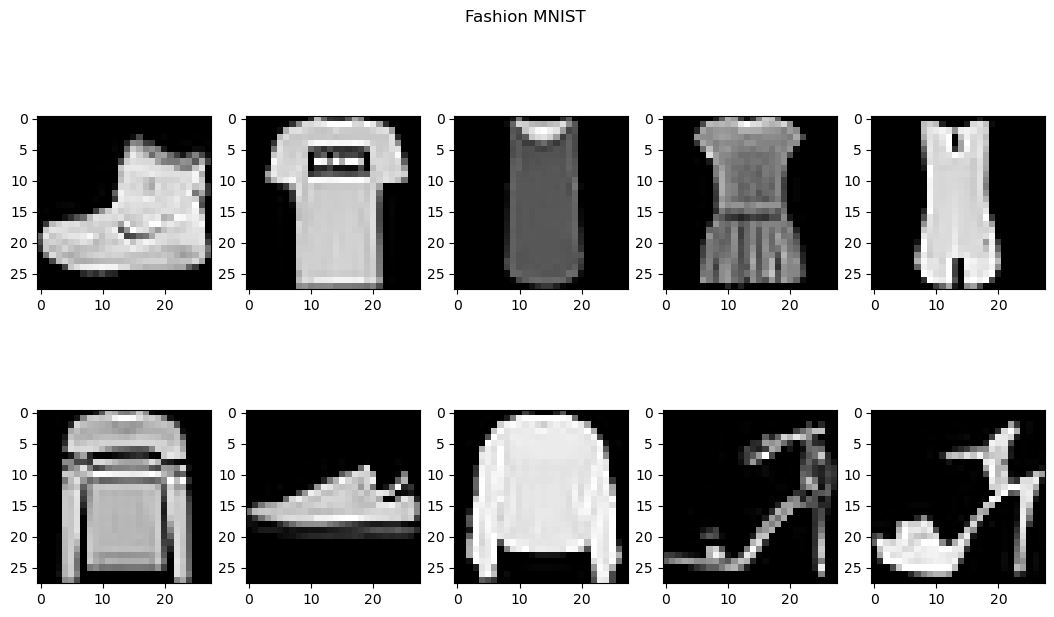

In [7]:
# FashionMNIST dataset
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])
train_data = FashionMNIST(root=".", train=True, transform=transforms, download=True)

batch_size = 256
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

_, axes = plt.subplots(2, 5, figsize=(13, 7))
for im, ax in zip(train_data.data[:10], axes.reshape(-1)):
    ax.imshow(im, cmap="gray")
plt.suptitle("Fashion MNIST")
plt.show()


## Zadanie 3: WAE-MMD (3 pkt.)
W ramach zadania należy:
1. Zaimplementować architekturę autoenkodera (enkoder + dekoder), podobną do tej zaprezentowanej w Zadaniu 1. Jako że dataset FMNIST jest trudniejszy, to architektura też powinna być istotnie większa (np. 50 wymiarów przestrzeni ukrytej).
2. Zaimplementować pętlę uczenia WAE, w której minimalizujemy koszt $\mathcal{L}_{WAE-MMD}$.
3. Dostosować hiperparametry (learning rate, liczba epok, $C$, $\sigma$, etc.), tak żeby rekonstrukcja i generowane sample wyglądały na poziomie porównywalnym do tych pokazanych poniżej (albo lepiej). Zacznij od $C=1$, $\sigma = 2D$, gdzie $D$ to wymiar przestrzeni ukrytej.

W razie potrzeby można wspomóc się materiałami z wykładu, [oryginalną pracą o autoenkoderze Wassersteina](https://arxiv.org/abs/1711.01558) (interesuje nas zwłaszcza strona piąta, Algorytm 2 WAE-MMD) oraz [oficjalnie dostępną implementacją](https://github.com/tolstikhin/wae). 



In [13]:
class WAEMMD(nn.Module):
    
    def __init__(self, latent_dim: int):
        
        super(WAEMMD, self).__init__()
        
        self.latent_dim = latent_dim
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(784,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,self.latent_dim)
        )
        self.decoder =torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,784),
            torch.nn.Sigmoid()
        )
        
    def decode(self, encoded: torch.Tensor):
        return self.decoder(encoded)
    
    def encode(self, x: torch.Tensor):
        return self.encoder(x)

    def forward(self, x: torch.Tensor):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return encoded, decoded
    
    def mmd_loss(self, y: torch.Tensor, sigma: float):
        P = torch.randn(100,self.latent_dim)
        Q = self.encode(y)
        suma1 = 0
        suma2=0
        suma3=0
        P,Q =P.cuda(),Q.cuda()
        for i in range(P.size(dim=0)):
            for j in range(P.size(dim=0)):
                suma1 +=torch.exp(-1*((torch.linalg.norm(P[i,:]-P[j,:]))**2)/(2*(sigma**2)))
            for n in range(Q.size(dim=0)):
                suma2+= torch.exp(-1*((torch.linalg.norm(P[i,:]-Q[n,:]))**2)/(2*(sigma**2)))
                for k in range(Q.size(dim=0)):
                    suma3+=torch.exp(-1*((torch.linalg.norm(Q[k,:]-Q[n,:]))**2)/(2*(sigma**2)))
        suma1 = suma1 / (P.size(dim=0)**2)
        suma2 = suma2/(P.size(dim=0)*Q.size(dim=0))
        suma3 = suma3/(Q.size(dim=0)*Q.size(dim=0))
        return suma1 - 2*suma2 + suma3 

In [ ]:
def plot_samples(model):
    # Important part - sampling from normal distribution and passing the results through the decoder.
    sampled_z = torch.randn(20, model.latent_dim).cuda()
    generated = model.decode(sampled_z)

    # Plotting the results
    generated = generated.cpu().detach().numpy()
    _, axes = plt.subplots(2, 10, figsize=(15, 4))
    for gen_im, ax in zip(generated, axes.reshape(-1)):
        ax.imshow(gen_im.reshape(28, 28), cmap="gray")
    plt.suptitle("Generated samples")
    plt.show()

sigma: float = 100
C: float = 1
epochs: int = 25
model = WAEMMD(50).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
class WAELoss(nn.Module):
    def __init__(self, model, sigma: float, C: float = 1.0):
        super(WAELoss, self).__init__()
        
        self.model = model  
        self.mse_loss = nn.MSELoss() 
        
        self.sigma = sigma  
        self.C = C  
    
    def forward(self, x):
        encoded, decoded = self.model(x)
        reconstruction_loss = self.mse_loss(decoded, x)
        mmd_loss_value = self.C*self.model.mmd_loss(x, self.sigma)
        total_loss = reconstruction_loss + mmd_loss_value
        return total_loss 
wae = WAELoss(model,sigma,C).cuda()
for epoch in range(epochs):
    print(epoch)
    for step, (x, y) in enumerate(train_loader):
        x,y = x.cuda(),y.cuda()
        optimizer.zero_grad() 
        loss_val = wae.forward(x)
        loss_val.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients
    if epoch % 10 == 0:
        plot_dataset(train_data, wae)
        plot_pca(train_data, wae)
        plot_samples(wae)

0


## Więcej materiałów o modelach generatywnych

* [Wykład o uczeniu nienadzorowanym i VAE](https://www.youtube.com/watch?v=f0s-uvvXvWg&list=PLqYmG7hTraZCDxZ44o4p3N5Anz3lLRVZF&index=10) - Interesujący wykład badaczy z DeepMindu zagłebiający się w to, dlaczego nienadzorowane uczenie się reprezentacji jest cenne i jak wykorzystać do tego VAE (model podobny do WAE). Polecamy też pozostałe wykłady z serii.
* [Cramer-Wold Autoencoder](https://arxiv.org/abs/1805.09235) - jak zaimplementować koszt WAE-MMD bez potrzeby samplowania w przestrzeni ukrytej?
